# Flatiron Capstone Project

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **1/19/24**

Instructor name: **Mark Barbour**

# Stakeholder
The stakeholder is a social media communications team working for a political candidate, Donald Trump. They have requested that you analyze a body of social media posts from their voter base and extract meaningful insights on their base's attitudes.

# Importing Packages and Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import time
from tqdm.notebook import tqdm
import os
import joblib

import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from statsmodels.regression import linear_model as lr

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Many data files are too large to store on GitHub;
# I stored them on Kaggle instead.
# This notebook will download them from my Kaggle account
# using my username and api key.

os.environ['KAGGLE_USERNAME'] = "jellomcfello"
os.environ['KAGGLE_KEY'] = "7905b1d29e1a8d4fe0fc321da30b663d"

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

kaggle.api.dataset_download_files('jellomcfello/the-donald-comments/', path='data/', unzip=True)
kaggle.api.dataset_download_files('jellomcfello/the-donald-training-data/', path='data/training_data', unzip=True)
kaggle.api.dataset_download_files('jellomcfello/the-donald-grams/', path='data/', unzip=True)

In [3]:
# Reading newly downloaded data

with open('data/sample_post.pkl', 'rb') as f:
    sample_post = joblib.load(f)

original = pd.read_parquet(path='data/the_donald_comments.parquet')
preprocessed = pd.read_parquet(path='data/the_donald_comments_preprocessed.parquet')
spam = pd.read_parquet(path='data/the_donald_comments_spam.parquet')

top_unigrams = pd.read_parquet(path='data/the_donald_comments_unigrams.parquet')
top_bigrams = pd.read_parquet(path='data/the_donald_comments_bigrams.parquet')
top_trigrams = pd.read_parquet(path='data/the_donald_comments_trigrams.parquet')

unigram_features = pd.read_parquet(path='data/training_data/the_donald_comments_unigram_features.parquet')
bigram_features = pd.read_parquet(path='data/training_data/the_donald_comments_bigram_features.parquet')
trigram_features = pd.read_parquet(path='data/training_data/the_donald_comments_trigram_features.parquet')
targets = pd.read_parquet(path='data/training_data/the_donald_comments_targets.parquet')

dates = targets.date
scores = targets.score
vader = targets.vader

# Helper Functions

In [4]:
# Random state for any function that uses one
state = 42

In [5]:
def linear_model(x, y):
    
    """
    1) Performs a train-test split.
    2) Initializes a linear regression model.
    3) Fits the model.
    4) Selects only significant (p<0.05) coefficients.
    5) Sorts coefficients into positive and negative.
    6) Calculates predictions for train and test sets.
    7) Calculates MAE and RMSE error metrics for both sets of predictions.
    8) Calculates residuals for both sets of predictions.
    9) Returns a dictionary with all this information.
    """
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=0.2)
    target = y.name
    formula = f"{target} ~ " + ' + '.join([col for col in X.columns])

    # Fits model
    base_model = lr.OLS.from_formula(formula, data=pd.concat([y_train, X_train], axis=1))
    results = base_model.fit(disp=True)

    # Sorts coefficients into positive and negative
    results_as_html = results.summary().tables[1].as_html()
    coefficients_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    coefficients_df.columns = ['coef', 'std_err', 't', 'p_of_t', 'cf_lower', 'cf_upper']
    positive_words = coefficients_df.query('coef>0 & p_of_t<0.05').sort_values(by='coef', ascending=True)
    negative_words = coefficients_df.query('coef<0 & p_of_t<0.05').sort_values(by='coef', ascending=True)

    # Calculates train and test predictions
    train_predictions = results.predict(X_train)
    test_predictions = results.predict(X_test)

    # Calculates error metrics for both sets of predictions
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    # Calculates residuals for both sets of predictions
    test_residuals = test_predictions.sub(y_test)
    train_residuals = train_predictions.sub(y_train)
    
    # Calculates r squared for both sets of predictions
    test_r2 = r2_score(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    return  {'x_train': X_train, 
            'y_train': y_train, 
            'x_test': X_test, 
            'y_test': y_test, 
            'coefficients': coefficients_df, 
            'positive_words': positive_words, 
            'negative_words': negative_words, 
            'train_predictions': train_predictions, 
            'test_predictions': test_predictions, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_rmse': train_rmse, 
            'test_rmse': test_rmse, 
            'train_r2': train_r2, 
            'test_r2': test_r2,
            'train_residuals': train_residuals, 
            'test_residuals': test_residuals, 
            'results': results}

In [97]:
def top_words(results, large=False):
    
    """
    Takes in a dictionary returned by the linear_model function above.
    Returns a visualization of the top 20 positive and negative words.
    A "positive" word is a word with a positive coefficient in the regression model.
    A "negative" word is a word with a negative coefficient in the regression model.
    All available coefficients are significant (p<0.05).
    """
    positive_words = results['positive_words'].sort_values(by='coef', ascending=True).tail(10)
    negative_words = results['negative_words'].sort_values(by='coef', ascending=False).tail(10)
    
    if large:
        titlefont = 25
        labelfont = 20
        figsize=(12,15)
    else:
        titlefont = 10
        labelfont = 10
        figsize=(15,10)

    fig, axes = plt.subplots(1,2, figsize=figsize)
    axes[0].set_title("Top positive words", fontsize=titlefont)
    axes[0].tick_params(axis='y', which='major', labelsize=labelfont)
    axes[0].barh(positive_words.index, positive_words.coef.head(20))
    axes[1].set_title("Top negative words", fontsize=titlefont)
    axes[1].tick_params(axis='y', which='major', labelsize=labelfont)
    axes[1].barh(negative_words.index, negative_words.coef.head(20))
    axes[1].tick_params(axis='y', direction='inout', labelright=True, labelleft=False)

In [7]:
def plot_error(results, target):
    
    """
    Plots visualizations for the MAE and r2 metrics for train and test predictions.
    """
    
    # Rounds metrics to 3 decimal places for aesthetics
    train_mae = round(results['train_mae'], 3)
    test_mae = round(results['test_mae'], 3)
    train_r2 = round(results['train_r2'], 3)
    test_r2 = round(results['test_r2'], 3)

    fig,axes = plt.subplots(1,2, figsize=(20,5))
    
    barplot = axes[0].bar(['Train data', 'Test data'], [train_mae, test_mae])
    axes[0].set_title("Mean Absolute Errors")
    axes[0].set_ylabel(f"MAE for {target}")
    axes[0].bar_label(barplot, 
                      labels=[train_mae, test_mae], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');

    barplot = axes[1].bar(['Train data', 'Test data'], [train_r2, test_r2])
    axes[1].set_ylabel("R-squared value")
    axes[1].bar_label(barplot, 
                      labels=[train_r2, test_r2], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');
    
    axes[1].set_title("R-Squared Values (min=0, max=1)");

In [8]:
def actual_predicted_scatterplot(results, target, line=True):
    
    """
    Plots actual values against predicted values.
    The scatter plot is supposed to fall along the x=y line.
    If you want this line to see how good model predictions are, set line=True.
    If you find this line distracting, set line=False.
    """
    
    train_predictions = results['train_predictions'].copy()
    test_predictions = results['test_predictions'].copy()
    y_train = results['y_train'].copy()
    y_test = results['y_test'].copy()
    
    # Scatterplot #1
    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(y_test, test_predictions, alpha=0.002, s=10)
    ax.set_xlabel(f"Actual {target} values")
    ax.set_ylabel(f"Predicted {target} values")
    if line:
        ax.scatter(np.linspace(y_test.min(), y_test.max(),1000), 
                   np.linspace(y_test.min(), y_test.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title(f"Test {target} values vs. test {target} predictions");
    
    
    # Scatterplot #2
    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(y_train, train_predictions, alpha=0.002, s=10)
    ax.set_xlabel(f"Actual {target} values")
    ax.set_ylabel(f"Predicted {target} values")
    if line:
        ax.scatter(np.linspace(y_train.min(), y_train.max(),1000),
                   np.linspace(y_train.min(), y_train.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title(f"Train {target} values vs. train {target} predictions");

In [9]:
def actual_predicted_timeseries(results, target):
    """
    Plots aggregated actual and predicted values across time.
    """
    
    train_predictions = results['train_predictions'].copy()
    test_predictions = results['test_predictions'].copy()
    y_train = results['y_train'].copy()
    y_test = results['y_test'].copy()
    
    # Sets index to date-time for aggregated plots
    train_predictions = train_predictions.sort_index()
    train_predictions.index = dates[dates.index.isin(train_predictions.index)]
    test_predictions = test_predictions.sort_index()
    test_predictions.index = dates[dates.index.isin(test_predictions.index)]
    y_train = y_train.sort_index()
    y_train.index = dates[dates.index.isin(y_train.index)]
    y_test = y_test.sort_index()
    y_test.index = dates[dates.index.isin(y_test.index)]
    
    # Aggregated plot #1
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(\
                 train_predictions[(train_predictions.index>'2016-02-01') & 
                                   (train_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    
    axes[0].plot(\
                 y_train[(y_train.index>'2016-02-01') &
                         (y_train.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='actual')
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(f"Predicted value for {target}")
    axes[0].set_title(f"Aggregated time series of train values and train predictions for {target}")
    axes[0].legend();
    
    
    # Aggregated plot #2
    axes[1].plot(\
                 test_predictions[(test_predictions.index>'2016-02-01') & 
                                  (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    axes[1].plot(\
                 y_test[(test_predictions.index>'2016-02-01') & 
                        (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='original')
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Predicted value for {target}")
    axes[1].set_title(f"Aggregated time series of test values and test predictions for {target}")
    axes[1].legend();

In [10]:
def residuals(results):
    """
    1) Graphs a histogram for test and train residuals.
    2) Graphs a scatterplot over time for test and train residuals.
    """
    
    train_residuals = results['train_residuals']
    test_residuals = results['test_residuals']
    
    train_residuals = train_residuals.sort_index()
    train_residuals.index = dates[dates.index.isin(train_residuals.index)]
    test_residuals = test_residuals.sort_index()
    test_residuals.index = dates[dates.index.isin(test_residuals.index)]
    
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/100000))
    axes[0].yaxis.set_major_formatter(ticks_y)
    axes[0].hist(train_residuals, bins=100)
    axes[0].set_title("Histogram of train residuals")
    axes[0].set_xlabel("Residual value")
    axes[0].set_ylabel("Count (in hundreds of thousands)")
    axes[1].yaxis.set_major_formatter(ticks_y)
    axes[1].hist(test_residuals, bins=100)
    axes[1].set_title("Histogram of test residuals")
    axes[1].set_xlabel("Residual value")
    axes[1].set_ylabel("Count (in hundreds of thousands)");
    
    train_residuals = train_residuals[\
                                      (train_residuals.index>'2016-02-01') & 
                                      (train_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    test_residuals = test_residuals[\
                                    (test_residuals.index>'2016-02-01') & 
                                    (test_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[0].set_title("Scatterplot of train residuals over time")
    axes[0].set_ylabel("Residual value")
    axes[1].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[1].set_title("Scatterplot of test residuals over time");
    axes[1].set_ylabel("Residual value")

In [11]:
def gridsearch(X, y):
    
    """
    Conducts a grid search for "alpha" and "penalty" parameters
    in a linear regression model.
    
    Returns:
    
    1) Best parameters found
    2) Best MAE score
    3) Best estimator's MAE score on test data
    4) All the coefficients of the best estimator
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

    param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l1', 'l2', 'elasticnet'],
    }

    sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3, random_state=state)
    grid_search = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)
    grid_search.fit(X_train, y_train)

    clear_output()

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_model = grid_search.best_estimator_
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, train_predictions) 
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    coefficients_df = pd.DataFrame({'gram': X_train.columns, 
                                    'coef': best_model.coef_}).sort_values(by='coef', ascending=True)
    
    return {'best_params': best_params, 
            'best_score': best_score, 
            'coefficients': coefficients_df, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_r2': train_r2, 
            'test_r2': test_r2, 
            'train_predictions': train_predictions,
            'test_predictions': test_predictions}

In [12]:
def analyze_model(results, line, target):
    """
    Creatures numerous visualizations with the help of other
    helper functions.
    """
    
    plot_error(results, target=target)
    top_words(results)
    actual_predicted_scatterplot(results, target=target, line=line)
    actual_predicted_timeseries(results, target=target)
    residuals(results)

# Data Prep

All steps taken in this section were performed in [the "data_prep" notebook](notebooks/data_prep.ipynb).

### Data: Origin
Data is taken from the former reddit titled ***r/the_donald***. This reddit has been archived along with 20,000 others on [the-eye.eu](https://the-eye.eu/redarcs/). If you want to download it yourself, you just need to type "the_donald" in the search bar on this website and download the "Comments" link provided there. [The "data_prep" notebook](notebooks/data_prep.ipynb) uses the following URL to download (if you click it, the file will start downloading on your computer):

- https://the-eye.eu/redarcs/files/The_Donald_comments.zst

Fair warning - if you are about to explore on this website, be cautious. I looked at some of the archived reddits and will never be the same again.

### Data: Statistics
The compressed file is sizeable at 3.8GB, but this is in .zst format. Once converted to a .txt file, it takes up a whopping 37.48 GB of space, containing data on approximately 48 million posts. Due to the sheer amount of data and the limitations of my machine, I was unwilling to analyze all 48 million posts. I wanted to take 2 million posts, so I kept every 23rd post from this file.

Each post is recorded as a dictionary. Only some of the keys were relevant to our analysis:
- Raw text
- Post score (upvotes - downvotes)
- Author
- Date posted

After extraction, our initial dataframe had 2.1 million total entries ranging from August of 2015 to April of 2020, for a total of 1710 days – approximately 4.5 years. There are 178,308 unique authors.

In [13]:
# An example of an un-altered post from the original reddit .txt file.

sample_post

{'author_flair_text': None,
 'ups': 2,
 'author': 'NYPD-32',
 'created_utc': '1438813243',
 'author_flair_css_class': None,
 'subreddit_id': 't5_38unr',
 'edited': False,
 'score': 2,
 'subreddit': 'The_Donald',
 'distinguished': None,
 'id': 'ctsvj09',
 'link_id': 't3_3fwi8m',
 'retrieved_on': 1440304981,
 'gilded': 0,
 'parent_id': 't1_ctso9rb',
 'controversiality': 0,
 'body': 'A lot of latinos are annoyed with illegal immigration too'}

In [14]:
# I took a sample of 2.1 million posts from the original reddit .txt file,
# and extracted the date, author, post, and post score.

# This is the dataframe holding that information.

original

,date,author,post,score
id,,,,
0,2015-08-05 22:19:44+00:00,NYPD-32,A lot of latinos are annoyed with illegal immi...,2
1,2015-08-09 23:51:28+00:00,shitheadsean2,"If Donald Trump liquidated everything, and the...",5
2,2015-08-13 19:16:16+00:00,NYPD-32,An*,7
3,2015-08-14 16:38:24+00:00,the_achiever,"I really support Trump, but he has to work on ...",1
4,2015-08-17 14:53:52+00:00,Degenerate_Nation,Two-part Trump-centric podcasts:\n\nhttp://www...,1
...,...,...,...,...
2093201,2020-04-09 21:21:21+00:00,[deleted],[deleted],1
2093202,2020-04-10 04:26:11+00:00,Fordheartskav,yes and yes. So many spez suckers lying about ...,1
2093203,2020-04-10 15:57:11+00:00,RhettOracle,Now it's brutality? You are so biased it's h...,1


In [15]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093206 entries, 0 to 2093205
Data columns (total 4 columns):
 #   Column  Dtype              
---  ------  -----              
 0   date    datetime64[ns, UTC]
 1   author  object             
 2   post    object             
 3   score   int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 63.9+ MB


In [16]:
print(f"The data contains {original.author.nunique()} unique authors.")

The data contains 178308 unique authors.


In [17]:
print(f"The earliest post is {original.date.min()}.")
print(f"The latest post is {original.date.max()}.")
print(f"The data spans {original.date.max() - original.date.min()}.")

The earliest post is 2015-08-05 22:19:44+00:00.
The latest post is 2020-04-11 18:49:38+00:00.
The data spans 1710 days 20:29:54.


# Preprocessing

All steps taken in this section were performed in [the preprocessing notebook](notebooks/preprocessing.ipynb).

### Removing hyperlinks and extraneous characters

- I used a regex to eliminate hyperlinks. The regex wasn't perfect, but it was very good. It reduced the number of posts with hyperlinks from 108,228 to just 229. That's a 99.8% reduction in posts with hyperlinks.
- There were several other combinations of characters we replaced, such as "&gt;" that repeated many times. These are longhand notations of certain special characters like ">" or "<". They can be looked up [on this website](https://www.htmlhelp.com/reference/html40/entities/special.html).

### Tokenizing posts
- Tokenizing strings is the process of separating them into lists, where each element is an individual word in that string. I used another regex that identified words and eliminated special characters such as punctuation.
- Tokenization enables easy stopword removal and the creation of bigrams and trigrams.

### Stopword removal
- Stopwords are commonly used words that significantly increase the burden on models while contributing very little. We removed stopwords contained in nltk's stopword list. This resulted in the removal of 22.3 million words, about half of all original words.

### Calculating post lengths
- Enables the removal of insanely long posts and create more reasonably distributed data.

### Creating bigrams and trigrams
- Individual words are one means of extracting insights from this data, but bigrams and trigrams carry more information than individual words. By extracting bigrams and trigrams, we have two more options for analysis and the potential to give more meaningful recommendations to our stakeholder.

### Removing bots
- All posts from the universal reddit moderator, AutoModerator, were removed.
- Posts with the words "bot made by u/reddit_username" were removed.
- Authors with the word "bot" or "Bot" in their name were removed.
- Posts with the words "I'm a bot" were removed.

These measures weren't perfect - they probably didn't remove all the bots, and they did remove some posts by real people. However, the vast majority of posts removed by these measures were made by bots.

If you're skeptical about the effectiveness of these measures, or you think they might have been too extensive, head to the Appendix at the end of this notebook. It shows you the kinds of posts each measure removed. These queries take up quite a bit of space, which is why I kept them at the end of the notebook.

### Capping post length at 200 words
- Looking at the distribution of post length, it was extremely skewed to the right. Capping post length at 200 words results in a much more reasonable distribution.

### Giving post score a hard boundary of (-25, 100)
- Looking at the distribution of post scores, it had long tails to both the right and left. A lower boundary of -25 and an upper boundary of 100 returned the distribution to a more reasonable state.

### Spam removal
- Removing posts longer than 200 words eliminated some spam, but not all.
- I used the most common unigrams, bigrams, and trigrams to locate any other spam.
    - Posts containing a unigram four or more times in a row were removed.
    - Posts containing a bigram three or more times in a row were removed.
    - Posts containing a trigram two or more times in a row were removed.
- Even after all these measures, trigrams such as "source script protect" continued to appear in the most common phrases. I manually removed these.
- All combined spam from this notebook is stored externally in a single dataframe, "spam.parquet."

In [18]:
# The result of preprocessing
preprocessed.head()

,date,author,post,score,hyperlinks_removed,tokenized,lowercase,stopwords_removed,joined,lengths,bigrams,trigrams
id,,,,,,,,,,,,
0,2015-08-05 22:19:44+00:00,NYPD-32,A lot of latinos are annoyed with illegal immi...,2,A lot of latinos are annoyed with illegal immi...,"[A, lot, of, latinos, are, annoyed, with, ille...","[a, lot, of, latinos, are, annoyed, with, ille...","[lot, latinos, annoyed, illegal, immigration]",lot latinos annoyed illegal immigration,10,"[[lot, latinos], [latinos, annoyed], [annoyed,...","[[lot, latinos, annoyed], [latinos, annoyed, i..."
1,2015-08-09 23:51:28+00:00,shitheadsean2,"If Donald Trump liquidated everything, and the...",5,"If Donald Trump liquidated everything, and the...","[If, Donald, Trump, liquidated, everything, an...","[if, donald, trump, liquidated, everything, an...","[donald, trump, liquidated, everything, donate...",donald trump liquidated everything donated equ...,22,"[[donald, trump], [trump, liquidated], [liquid...","[[donald, trump, liquidated], [trump, liquidat..."
2,2015-08-13 19:16:16+00:00,NYPD-32,An*,7,An*,[An],[an],[],,1,[],[]
3,2015-08-14 16:38:24+00:00,the_achiever,"I really support Trump, but he has to work on ...",1,"I really support Trump, but he has to work on ...","[I, really, support, Trump, but, he, has, to, ...","[i, really, support, trump, but, he, has, to, ...","[really, support, trump, work, speeches, felt,...",really support trump work speeches felt like h...,28,"[[really, support], [support, trump], [trump, ...","[[really, support, trump], [support, trump, wo..."
4,2015-08-17 14:53:52+00:00,Degenerate_Nation,Two-part Trump-centric podcasts:\n\nhttp://www...,1,Two-part Trump-centric podcasts: Spoiler: ...,"[Two, part, Trump, centric, podcasts, Spoiler,...","[two, part, trump, centric, podcasts, spoiler,...","[two, part, trump, centric, podcasts, spoiler,...",two part trump centric podcasts spoiler actual...,14,"[[two, part], [part, trump], [trump, centric],...","[[two, part, trump], [part, trump, centric], [..."


In [19]:
# The number of posts where hyperlinks were removed

len_before = len(original[original.post.str.contains('http')])
print(f"Number of posts with hyperlinks: {len_before}")

len_after = len(preprocessed[preprocessed.hyperlinks_removed.str.contains('http')])
print(f"Number of posts with hyperlinks after regex removal: {len_after}")

Number of posts with hyperlinks: 108228
Number of posts with hyperlinks after regex removal: 201


In [20]:
# Note: this figure will be different here than in the preprocessing notebook,
# becuase this figure is taken after all spam was removed.

num_words_after = len(preprocessed['stopwords_removed'].explode())
num_words_before = len(preprocessed['tokenized'].explode())

total_stopwords_removed = num_words_before - num_words_after
percentage_words_removed = total_stopwords_removed / num_words_before

print(f"A total of {total_stopwords_removed:,} stopwords were removed, \
which is {percentage_words_removed:.2%} of all original words.")

A total of 18,996,776 stopwords were removed, which is 49.48% of all original words.


In [21]:
# A preview of spam
spam.author.value_counts()

author
[deleted]            198575
AutoModerator         23027
TrumpTrain-bot         2454
MAGABrickBot           1882
trumpcoatbot           1387
                      ...  
xiviajikx                 1
stop_george_soros         1
FLCavScout                1
YepYepYeahYep             1
Shroudedf8                1
Name: count, Length: 8678, dtype: int64

# Feature Enginnering

Technically, we did minor feature engineering in [the preprocessing notebook](notebooks/preprocessing.ipynb) with bigrams and trigrams. All major feature engineering occurs in [the feature engineering notebook](notebooks/feature_engineering.ipynb).

### Sentiment analysis

Sentiment analysis was done with VADER (Valence Aware Dictionary sEntiment Reasoner). I discovered VADER through [this video by Rob Mulla](https://www.youtube.com/watch?v=QpzMWQvxXWk). Vader uses [a lexicon of about 7,500 words](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt) to calculate the probability of a piece of text being postive, negative or neutral. It also gives a compound score of sentiment based on these three probabilities, which is what we use to score sentiment.

[Neptune.ai](https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair#:~:text=Valence%20aware%20dictionary%20for%20sentiment,to%20calculate%20the%20text%20sentiment.&text=Positive%2C%20negative%2C%20and%20neutral.) describes VADER as being "optimized for social media data and can yield good results when used with data from twitter, facebook, etc." Since Reddit counts as social media, I believe VADER is a good choice for this project.

### Bag of words features

We have both of the target variables we need - score and sentiment. We are unable to use models meaningfully on our data as it currently stands. To create proper training data:

- I limited my vocabulary to the top 100 unigrams, bigrams, and trigrams. This was necessary because keeping all the words would have resulted in too many features.
- For each word/phrase in our vocabulary, I went through each post and determined whether the word/phrase was present.
- The result was three sparse matrices for unigrams, bigrams and trigrams.
- Due to limiting our vocabulary, many of the rows in these sparse matrices consisted entirely of 0's (that is, none of the words in our vocabulary were present in the given post). These rows do nothing but dilute the data and impeded the model's ability to make predictions, so all these rows were removed.

In [22]:
# These are the target variables that measure sentiment – score and 'sentiment',
# which means the VADER score.

targets[['score', 'vader']]

,score,vader
id,,
0,2,-0.7351
1,5,0.0000
2,7,0.0000
3,1,0.6240
4,1,0.0000
...,...,...
2093197,17,0.0000
2093198,19,-0.8689
2093199,4,0.1779


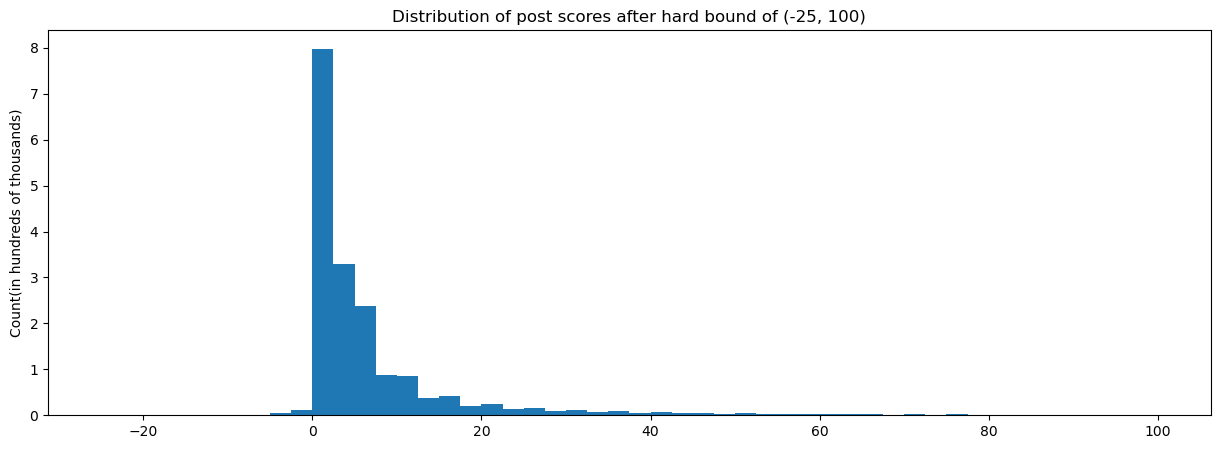

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(targets['score'], bins=50)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/100000))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel("Count(in hundreds of thousands)")
ax.set_title("Distribution of post scores after hard bound of (-25, 100)");

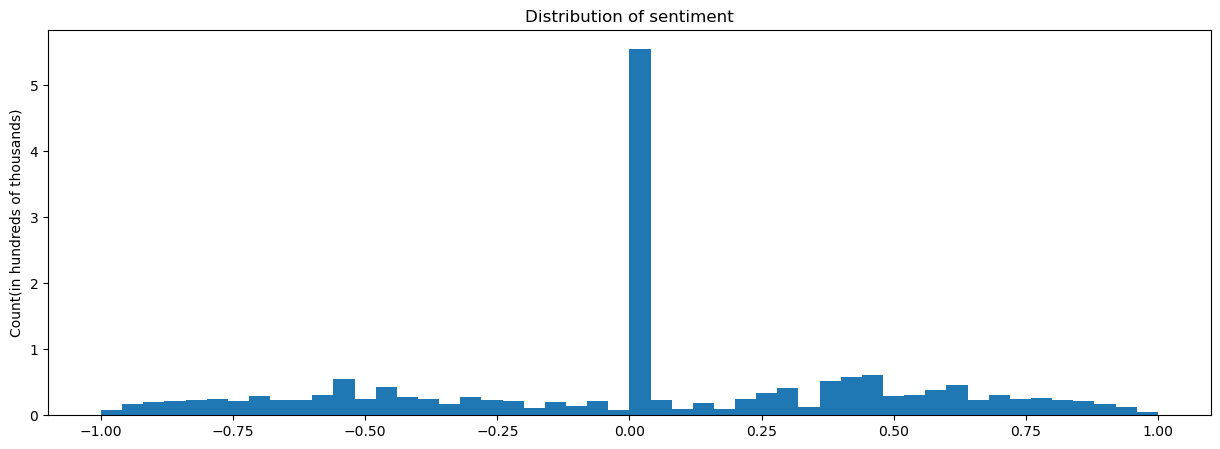

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(targets.vader, bins=50)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/100000))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel("Count(in hundreds of thousands)")
ax.set_title("Distribution of sentiment");

In [25]:
# These are the top 1000 most common single-words after spam removal, 
# a hard cap on post length of 200 words, and a hard boundary on post score
# of (-25, 100).

top_unigrams

,unigram,count
0,like,168772
1,people,151752
2,trump,148948
3,would,117866
4,get,108781
...,...,...
995,bless,3538
996,mad,3534
997,stopped,3532
998,speaking,3530


In [26]:
# These are the top 1000 most common two-word phrases.

top_bigrams

,bigram,count
0,"[looks, like]",11909
1,"[fake, news]",8092
2,"[president, trump]",7159
3,"[years, ago]",5924
4,"[sounds, like]",5503
...,...,...
995,"[health, insurance]",438
996,"[makes, us]",438
997,"[trump, made]",437
998,"[go, far]",437


In [27]:
# These are the top 1000 most common three-word phrases.

top_trigrams

,trigram,count
0,"[make, america, great]",1447
1,"[bill, clinton, rapist]",1225
2,"[fucking, white, male]",832
3,"[donald, j, trump]",831
4,"[orange, man, bad]",812
...,...,...
985,"[people, need, know]",57
984,"[year, old, kid]",57
982,"[keeps, getting, better]",57
981,"[someone, like, trump]",57


In [28]:
unigram_features

,_like,_people,_trump,_would,_get,_one,_think,_know,_even,_right,...,_yes,_pretty,_trying,_come,_post,_getting,_oh,_thought,_government,_already
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2093191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2093192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
bigram_features

,_looks_like,_fake_news,_president_trump,_years_ago,_sounds_like,_look_like,_donald_trump,_holy_shit,_white_people,_trump_supporters,...,_build_wall,_think_would,_ever_seen,_shit_like,_never_seen,_people_know,_people_get,_whole_thing,_10_years,_people_need
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2093108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2093143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
trigram_features

,_make_america_great,_bill_clinton_rapist,_fucking_white_male,_donald_j_trump,_orange_man_bad,_ten_feet_higher,_president_united_states,_つ_つ_つ,_long_time_ago,_new_york_times,...,_right_side_history,_brick_brick_brick,_god_emperor_trump,_makes_look_like,_usa_usa_usa,_holy_fucking_shit,_behind_closed_doors,_last_8_years,_wearing_maga_hat,_feel_like_going
id,,,,,,,,,,,,,,,,,,,,,
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
360,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2092789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2092793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

All modeling was done in [the modeling notebook](notebooks/modeling.ipynb). I only include the best models and their results in this notebook.

The model of choice was Linear Regression. The advantages of this model for this project are:

- It provides coefficients for all independent variables, making it interpretable;
- The coefficients can be positive or negative, so we know whether the independent variable positively or negatively impacted the target

We fit one model for each set of features, so we could analyze the model coaefficients separately for single-, two-, and three-word phrases.

### First Iteration

We started by using the "score" target variable. The results were very poor, with R-squared values of <0.1 for each model. These are so abysmal that I am not going to go into details for any of these models.

### Second Iteration

The second iteration of modeling used the "vader" target variable. The results were much better:

- Test R-squared for unigrams model: 0.245
- Test R-squared for bigrams model: 0.166
- Test R-squared for trigrams model: 0.326

Mean Absolute Error results:

- Test MAE for unigrams model: 0.33
- Test MAE for bigrams model: 0.433
- Test MAE for trigrams model: 0.363

### Third Iteration

The third iteration of modeling also used the "vader" target variable, but I eliminated all neutral scores from the dataset. The results were marginally better for R^2 but the MAE scores got slightly worse:

- Test R-squared for unigrams model: 0.249 (+0.003)
- Test R-squared for bigrams model: 0.168 (+0.002)
- Test R-squared for trigrams model: 0.344 (+0.018)

Mean Absolute Error results:

- Test MAE for unigrams model: 0.408 (+0.078)
- Test MAE for bigrams model: 0.468 (+0.035)
- Test MAE for trigrams model: 0.406 (+0.043)

### Fourth Iteration

The fourth iteration of modeling performed a hyperparameter grid search with the much faster SGDRegressor (also a linear regression model – just faster than the OLS version, and without significance values for the coefficients). The same data in the previous iteration was used for this one (with neutral VADER sentiment values removed). This iteration did not yield any improvements. All values were the same or slightly worse.

- Test R-squared for unigrams model: 0.249 (+0.00)
- Test R-squared for bigrams model: 0.168 (+0.00)
- Test R-squared for trigrams model: 0.333 (-0.011)

Mean Absolute Error results:

- Test MAE for unigrams model: 0.408 (+0.00)
- Test MAE for bigrams model: 0.469 (+0.001)
- Test MAE for trigrams model: 0.424 (+0.018)

# Visualizations

I make use of the same visualizations for each model that I create. For the first model, I will include a short description of the visulization and what it does. I will avoid repeating these descriptions elsewhere to avoid being repetitive.

# Results of Third Iteration (Best Iteration)

This is the iteration where we eliminated neutral VADER values from the data.

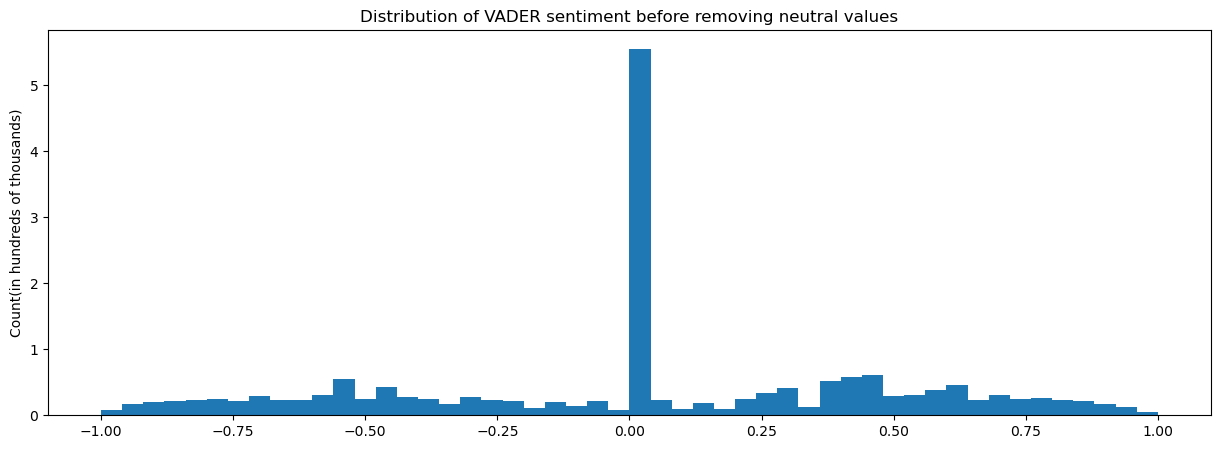

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(vader, bins=50)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/100000))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel("Count(in hundreds of thousands)")
ax.set_title("Distribution of VADER sentiment before removing neutral values");

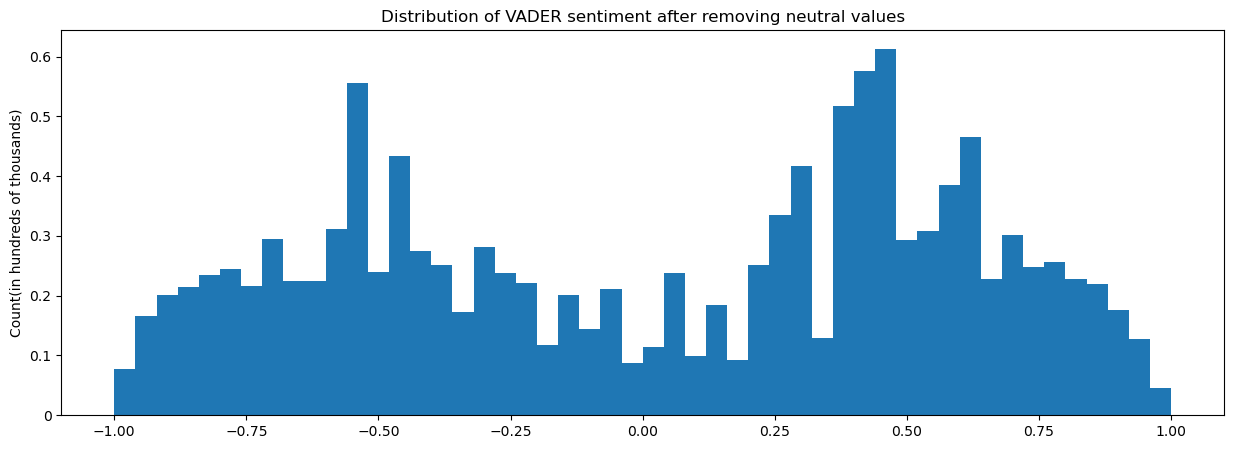

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
ax.hist(vader[vader!=0], bins=50)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/100000))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel("Count(in hundreds of thousands)")
ax.set_title("Distribution of VADER sentiment after removing neutral values");

## Unigrams

In [33]:
y = vader[(vader.index.isin(unigram_features.index)) & (vader!=0)]
X = unigram_features[unigram_features.index.isin(y.index)]

In [34]:
unigram_results = linear_model(X, y)

The first is a barplot of Mean Absolute Errors, for both train and test data.

The second is a barplot of R-squared values for both train and test data.

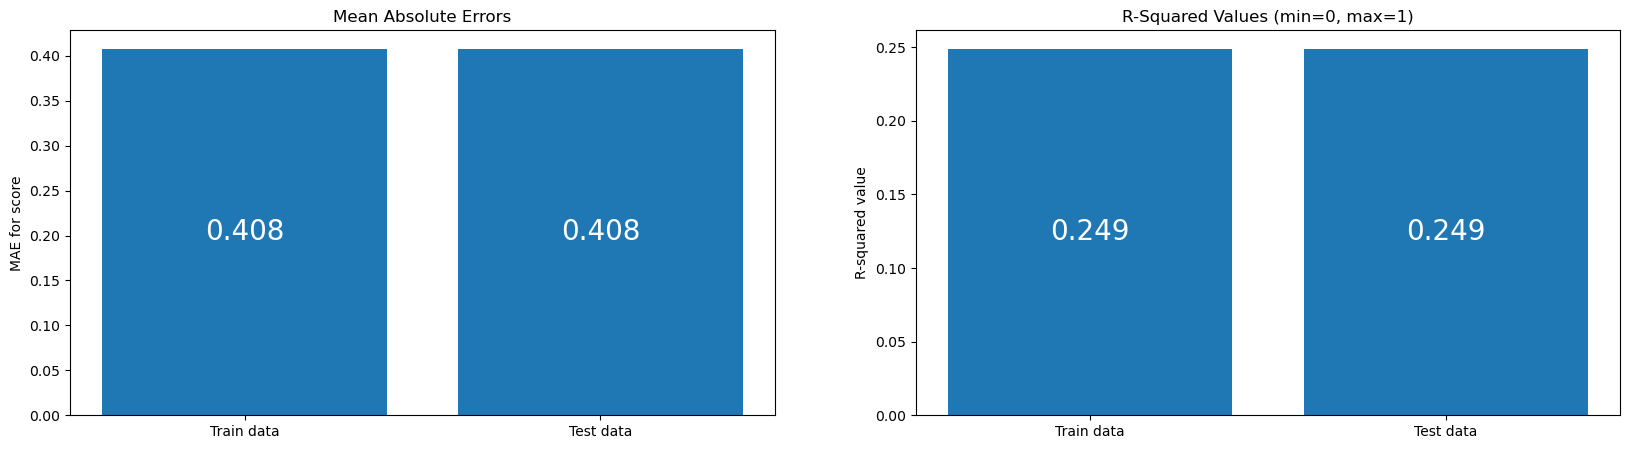

In [35]:
plot_error(unigram_results, "score")

The first is a horizontal barplot of the top 20 significant positive words.

The second is a horizontal barplot of the top 20 significant negative words.

"Significant" means that the linear regression model thought the word's coefficient
was significant at the alpha=0.05 level.

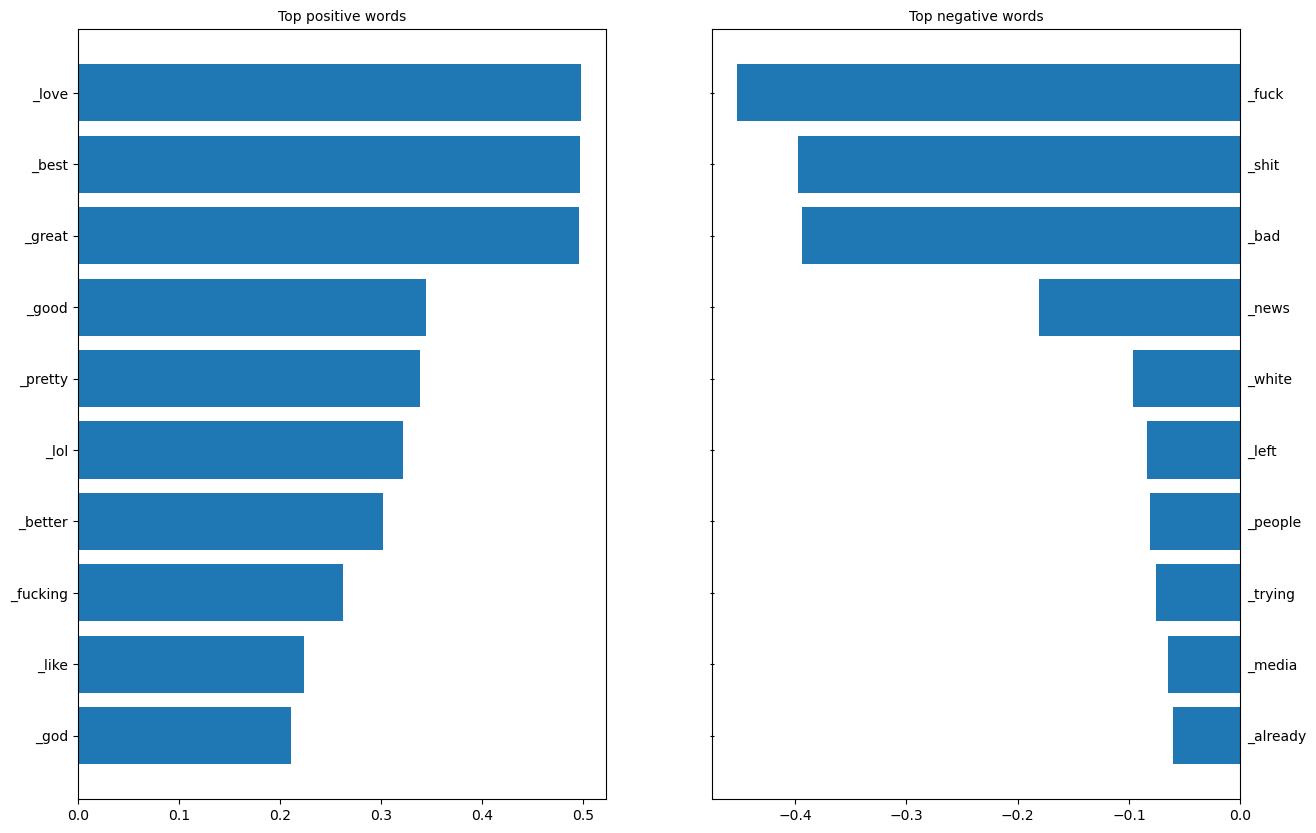

In [98]:
top_words(unigram_results)

The first is a scatterplot of actual values vs. model predictions.

Since you expect model predictions and actual values to be somewhat similar, this scatterplot will resemble an upward diagonal line if the model is good.

It's a good visual aid for someone looking to judge a model's performance.

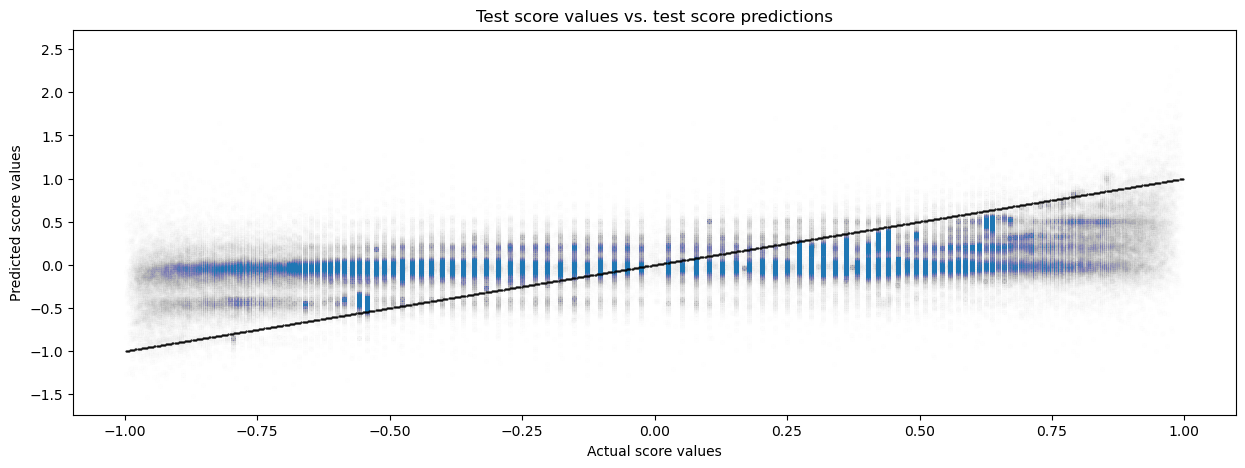

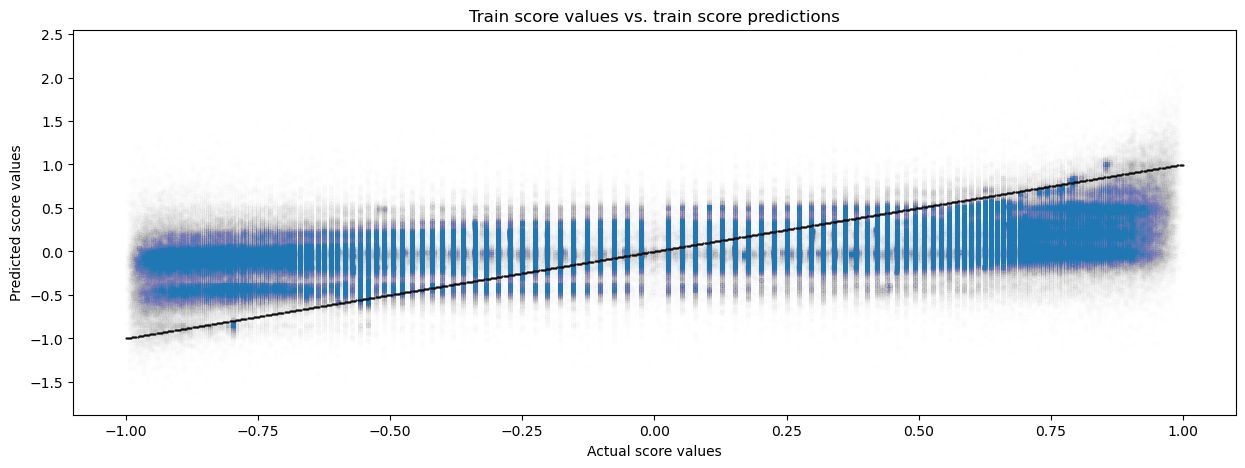

In [39]:
actual_predicted_scatterplot(unigram_results, "score")

The first is an aggregated time series for actual values and predicted values for train data.

The second is an aggregated time series for actual values and predicted values for test data.

"Aggregated" means that every point is average value over the course of an entire month.

For example, every point on the blue "predicted" line on the left-hand time series is the average
value over the course of an entire month in the train predictions.

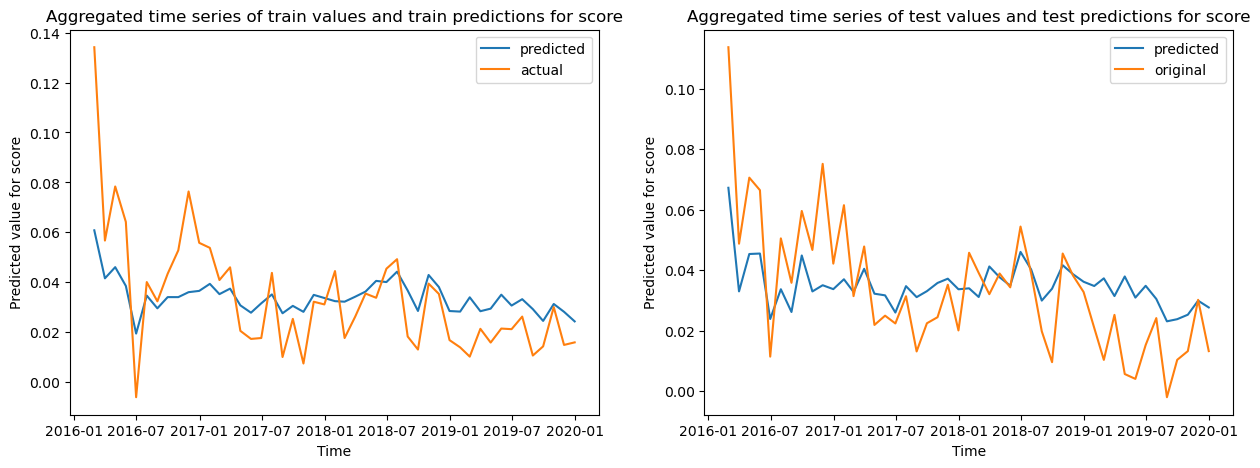

In [41]:
actual_predicted_timeseries(unigram_results, "score")

The top two visualizations are histograms of model residuals (the magnitude of error for each model prediction). These histograms should be approximately normally distributed, since linear regression assumes it.

The bottom two visualizations are scatterplots of residuals over time. It should be relatively uniform.

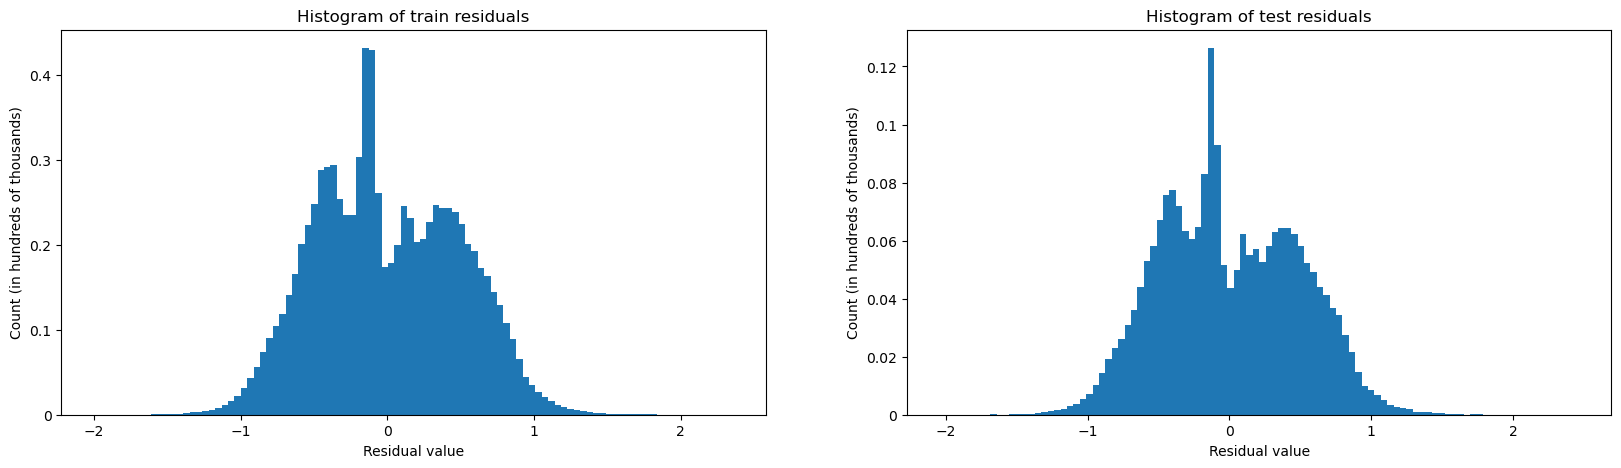

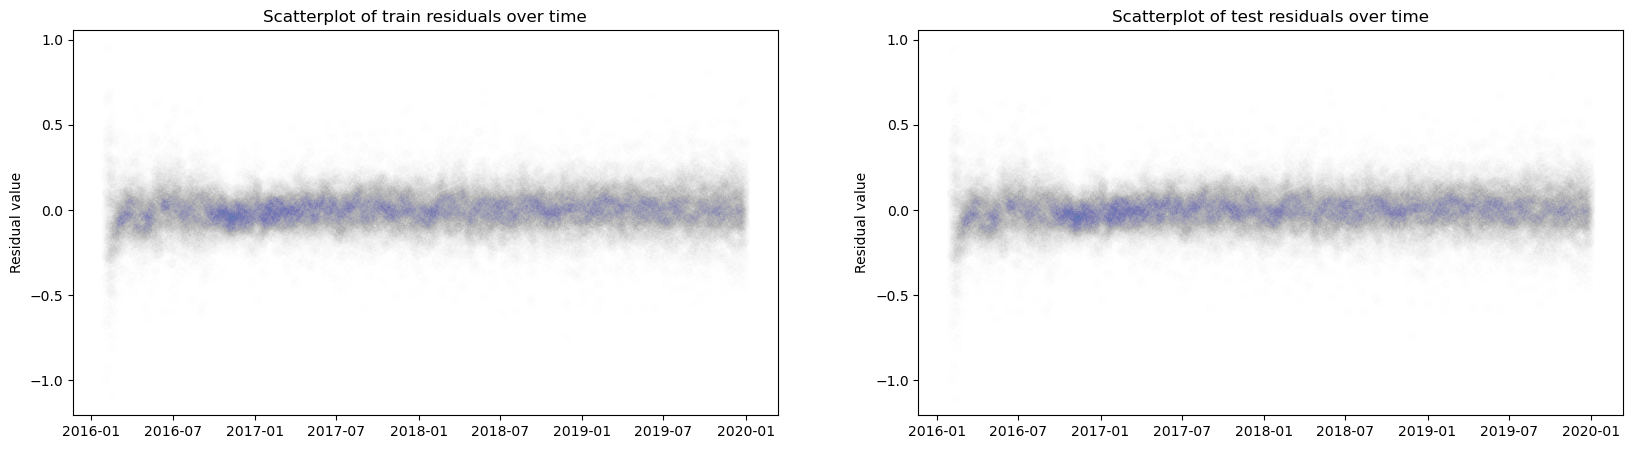

In [43]:
residuals(unigram_results)

## Bigrams

In [44]:
y = vader[(vader.index.isin(bigram_features.index)) & (vader!=0)]
X = bigram_features[bigram_features.index.isin(y.index)]

In [45]:
bigram_results = linear_model(X, y)

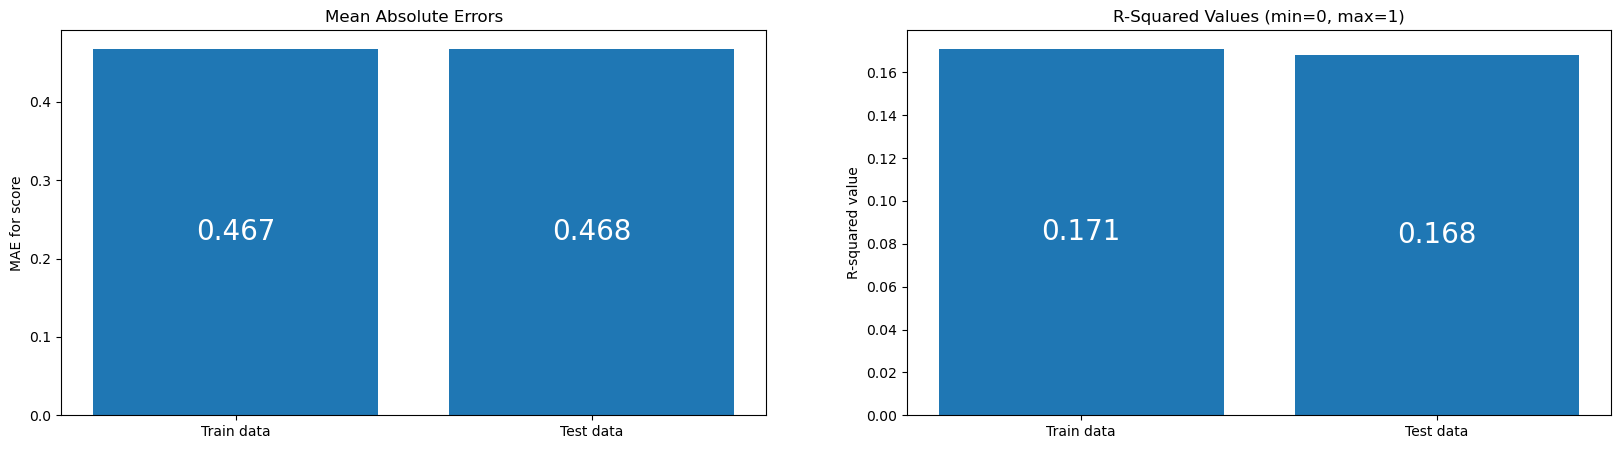

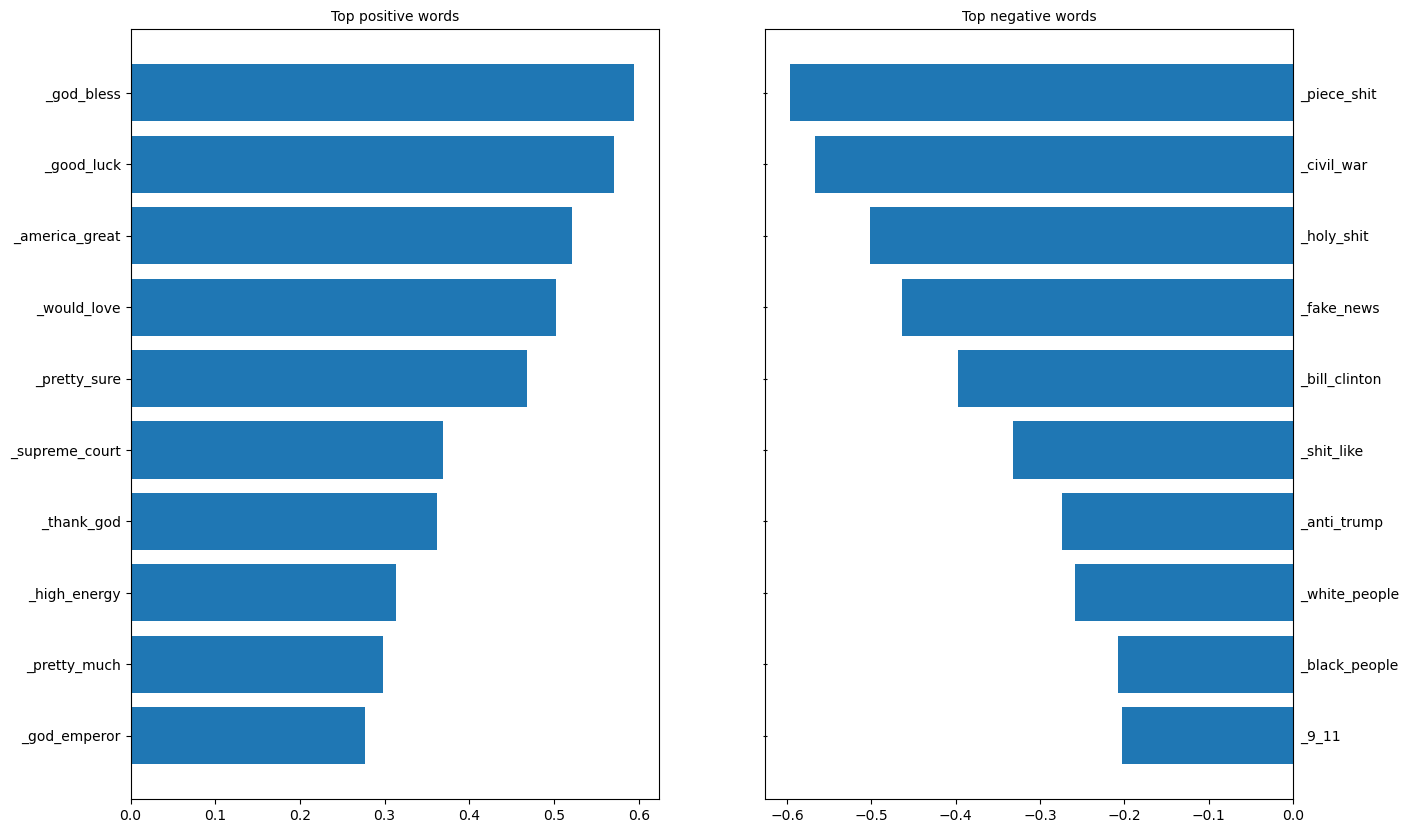

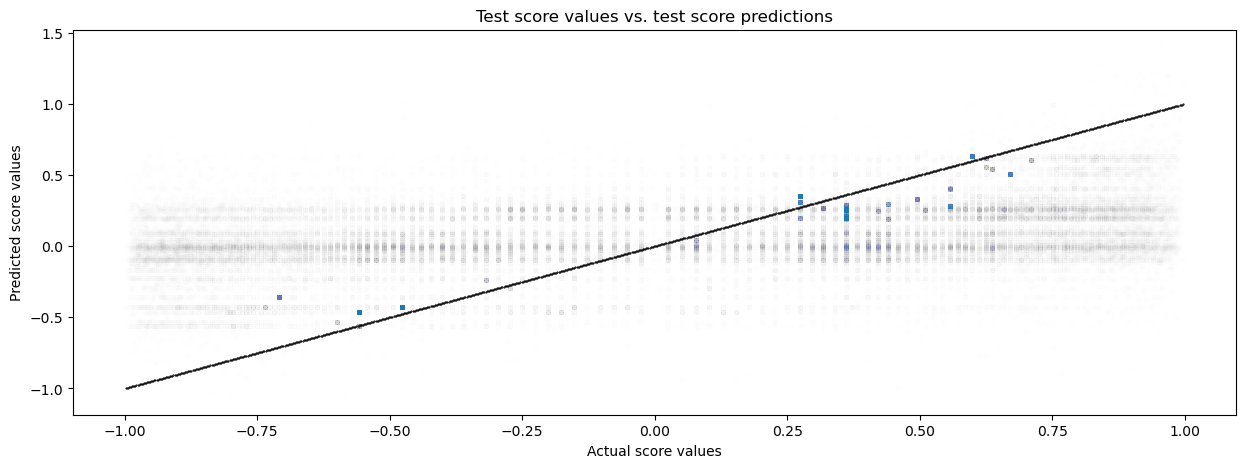

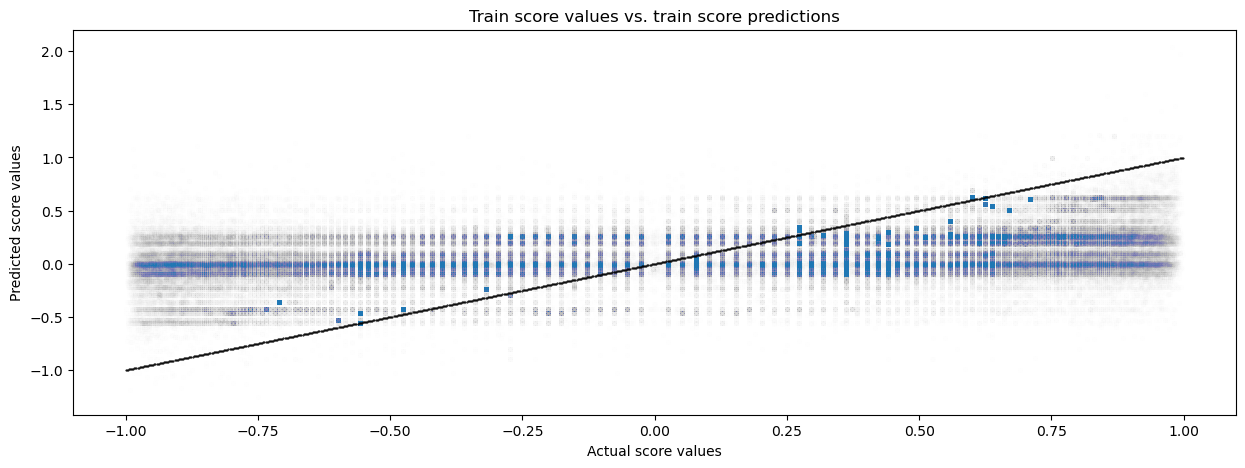

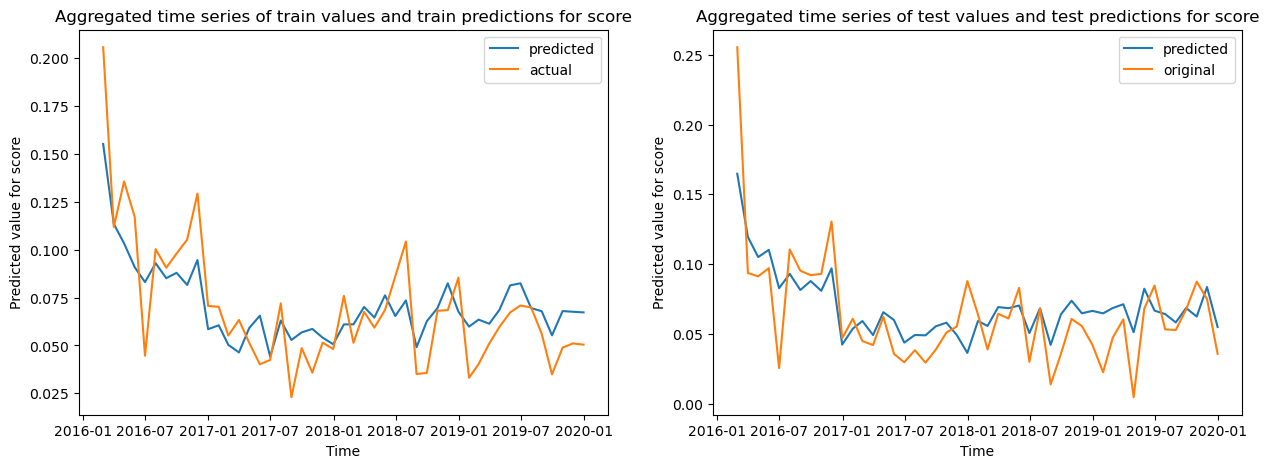

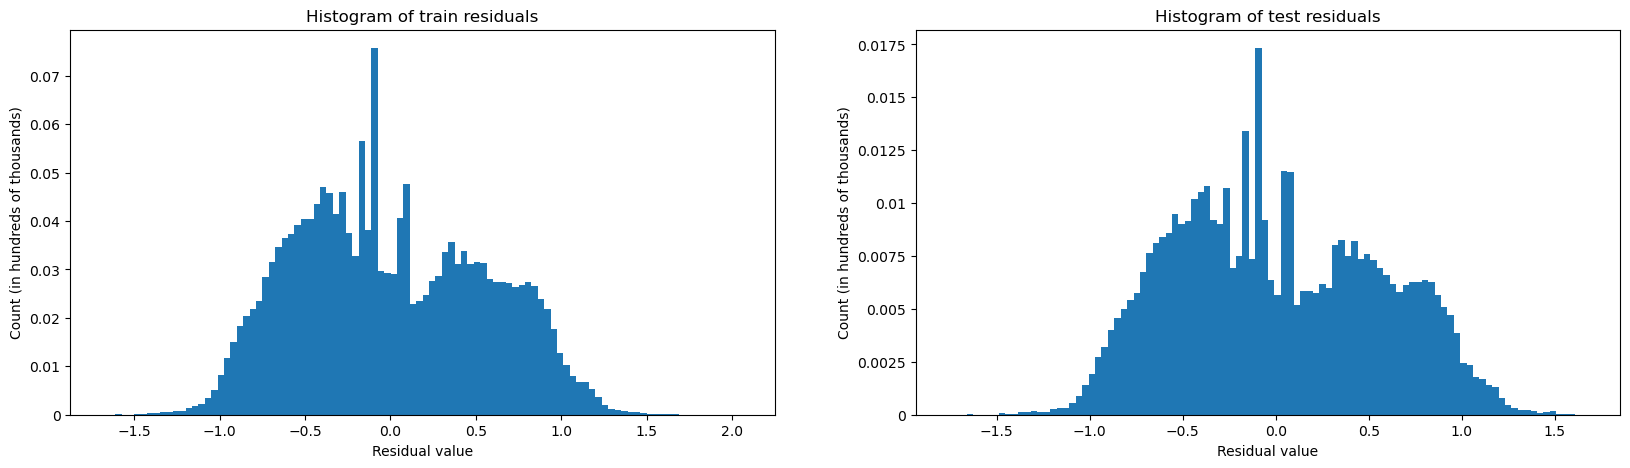

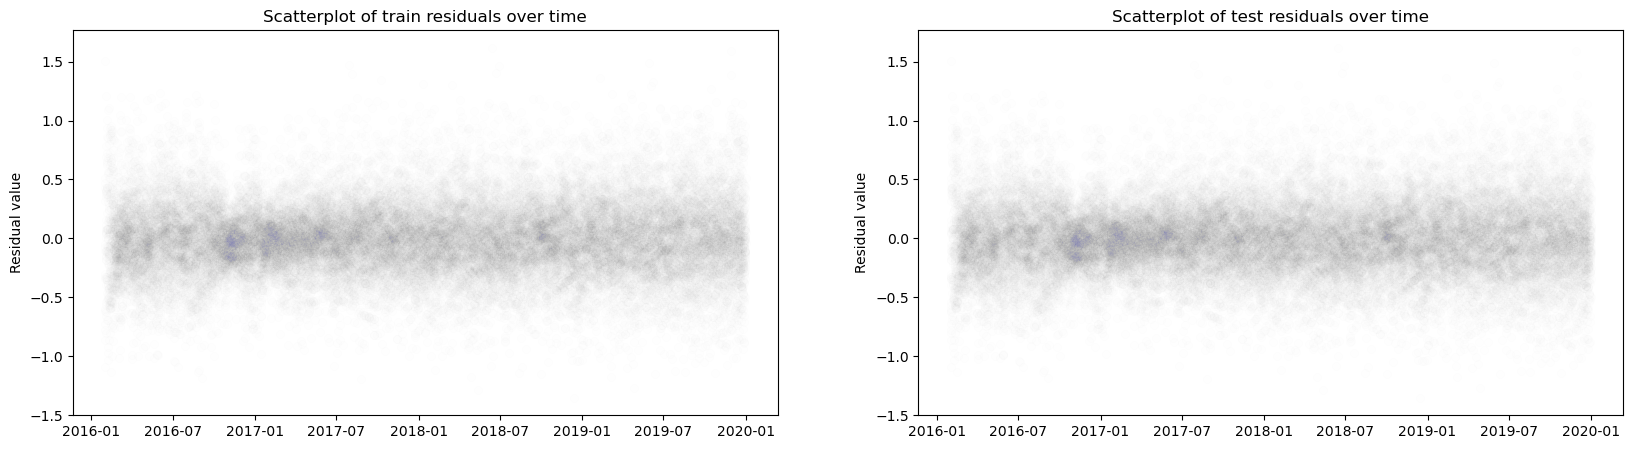

In [99]:
analyze_model(bigram_results, line=True, target="score")

## Trigrams

In [47]:
y = vader[(vader.index.isin(trigram_features.index)) & (vader!=0)]
X = trigram_features[trigram_features.index.isin(y.index)]

In [48]:
trigram_results = linear_model(X, y)

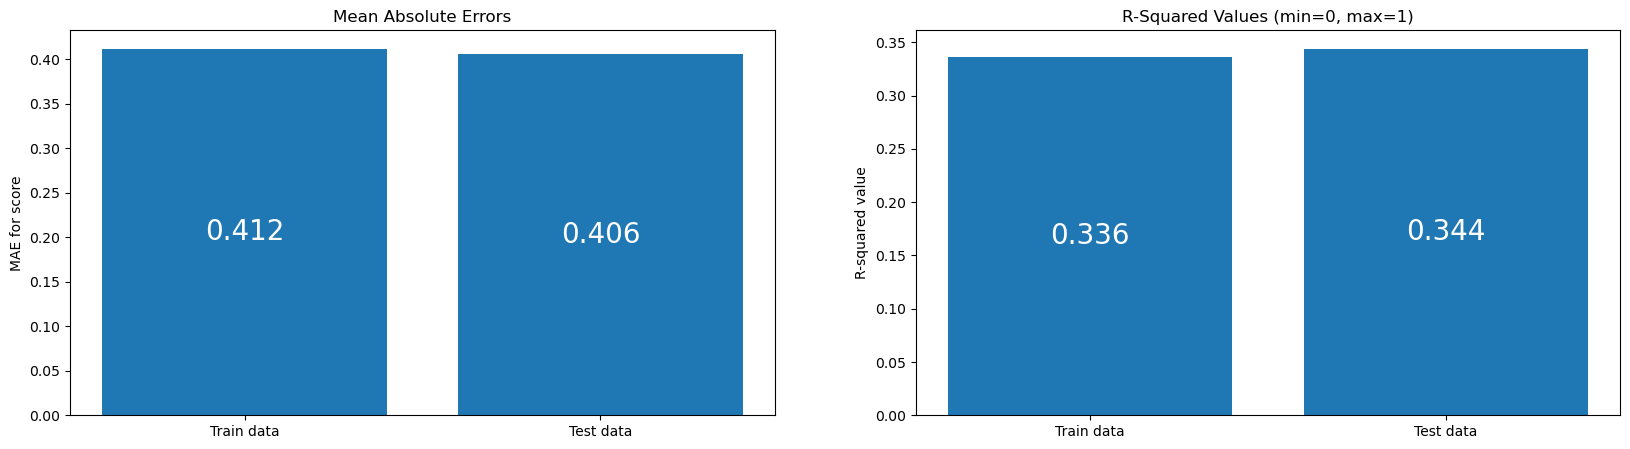

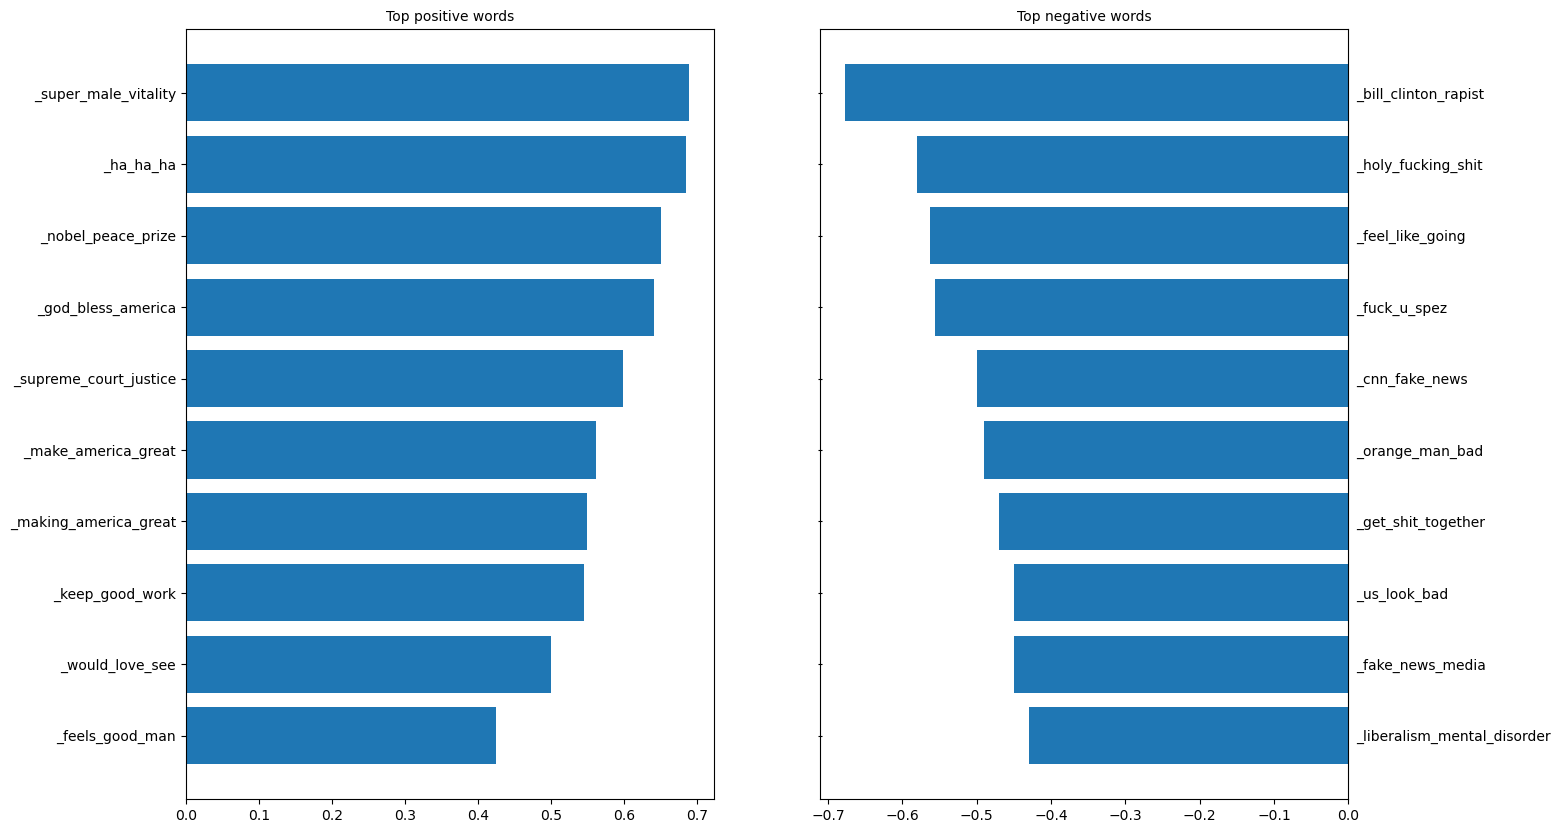

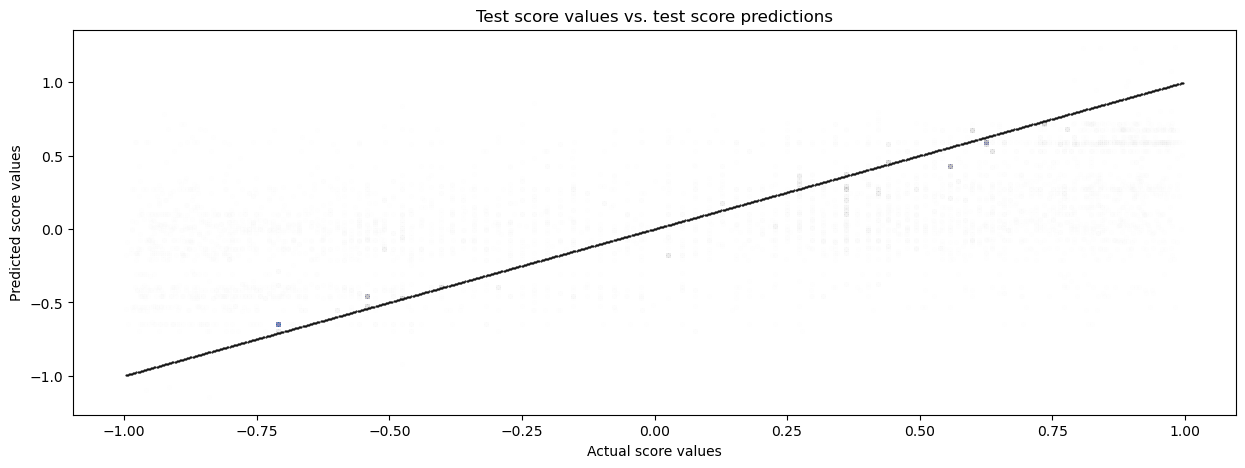

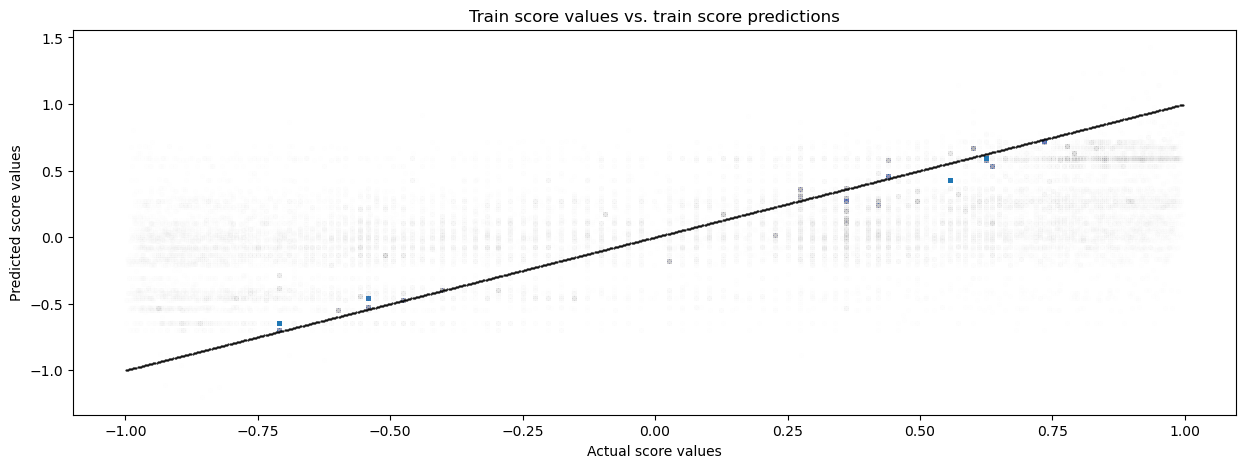

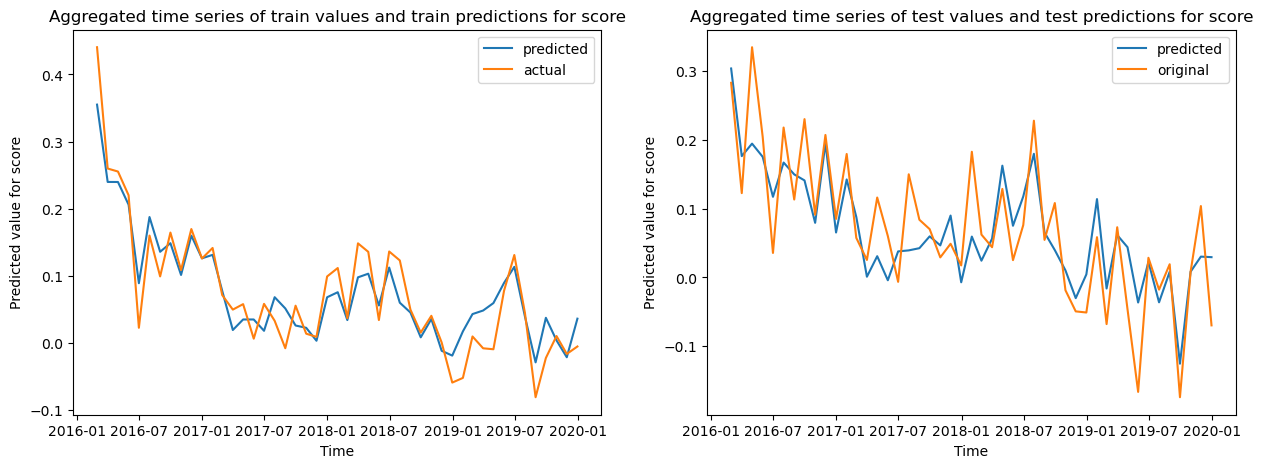

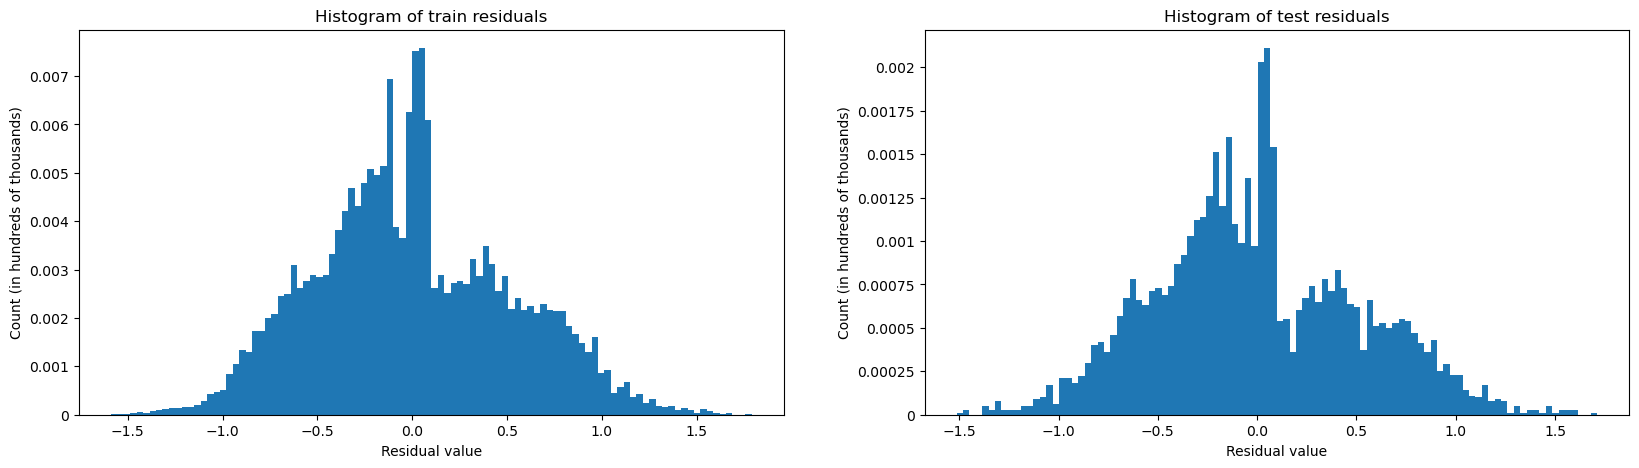

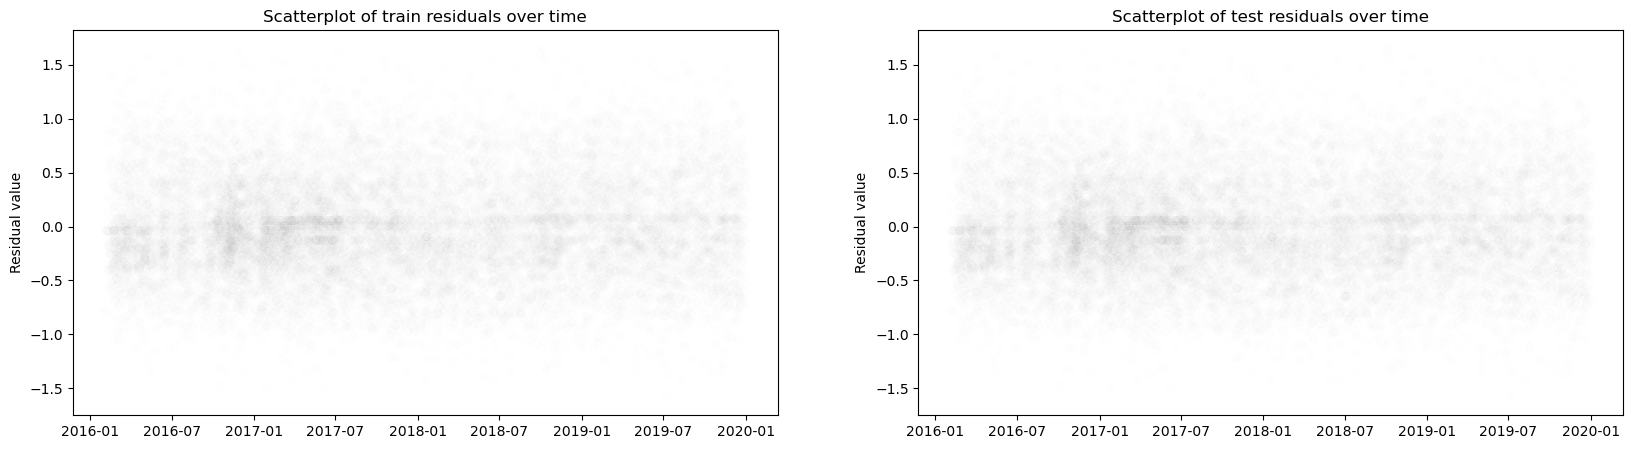

In [100]:
analyze_model(trigram_results, line=True, target="score")

# Recommendations

- Cater to the base’s religious tendencies. “God” appears in the most positive words and phrases – “God bless,” “Thank God,” “God bless America.”
- Speak fondly of the US, since the base holds it in high regard. “America great”, “United States”, “God bless America,” “make America great,” and “making America great” appear in the positive columns.

# Limitations

- We are only utilizing one social media platform, Reddit
- We are only utilizing a single subreddit